In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pytorch-msssim

In [3]:
import glob
import random
import os
import numpy as np

import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

import torch
from torch import nn
from matplotlib import pyplot as plt

from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

import argparse
import os
import numpy as np
import math
import itertools
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable

#from models import *
#from datasets import *

import torch.nn as nn
import torch.nn.functional as F
import torch

# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

from torchvision.models import vgg19

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)
    


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root, hr_shape):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                #transforms.Normalize(mean, std),
            ]
        )

        self.files = sorted(glob.glob(root + "/*.*"))

    def __getitem__(self, index):
        img_hr_path = self.files[index % len(self.files)]
        img_lr_path = img_hr_path.replace('high','generated')
        
        img_hr = Image.open(img_hr_path)
        img_lr = Image.open(img_lr_path)
        
        img_hr = self.transform(img_hr)
        img_lr = self.transform(img_lr)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)
    

In [ ]:
os.makedirs("/content/drive/MyDrive/SRGAN/images", exist_ok=True)
os.makedirs("/content/drive/MyDrive/SRGAN/saved_models", exist_ok=True)

In [ ]:
start_epoch = 100
n_epochs= 200
dataset_name = '/content/drive/MyDrive/SRGAN/DatasetBatches/high'
batch_size = 8
lr = 0.0002
b1 = 0.5
b2 = 0.999
decay_epoch = 100
n_cpu = 0
hr_height = 400
hr_width = 400
channels = 3
sample_interval = 100
checkpoint_interval = 1

In [ ]:
cuda = torch.cuda.is_available()

hr_shape = (hr_height, hr_width)

# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
cuda

True

In [ ]:
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

In [ ]:
if start_epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("/content/drive/MyDrive/SRGAN/saved_models/generator_"+str(start_epoch-1)+".pth"))
    discriminator.load_state_dict(torch.load("/content/drive/MyDrive/SRGAN/saved_models/discriminator_"+str(start_epoch-1)+".pth"))

In [ ]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [ ]:
dataloader = DataLoader(
    #ImageDataset("/content/drive/MyDrive/img_align_celeba", hr_shape=hr_shape),
    ImageDataset("%s" % dataset_name, hr_shape=hr_shape),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

In [ ]:
dataiter = iter(dataloader)
data = dataiter.next()

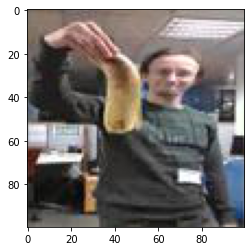

In [ ]:
i = 2
img = data['lr'][i].permute(1, 2, 0)
plt.imshow(img)

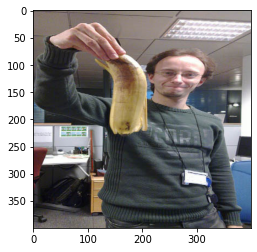

In [ ]:
img = data['hr'][i].permute(1, 2, 0)
plt.imshow(img)

In [ ]:
# ----------
#  Training
# ----------

for epoch in range(start_epoch, n_epochs):
    for i, imgs in enumerate(dataloader):

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)

        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())

        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        sys.stdout.write(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), loss_D.item(), loss_G.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            # Save image grid with upsampled inputs and SRGAN outputs
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            img_grid = torch.cat((imgs_lr, gen_hr), -1)
            save_image(img_grid, "/content/drive/MyDrive/SRGAN/images/%d.png" % batches_done, normalize=False)

    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), "/content/drive/MyDrive/SRGAN/saved_models/generator_%d.pth" % epoch)
        torch.save(discriminator.state_dict(), "/content/drive/MyDrive/SRGAN/saved_models/discriminator_%d.pth" % epoch)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import shutil
shutil.make_archive('SRGAN', 'zip', './SRGAN')